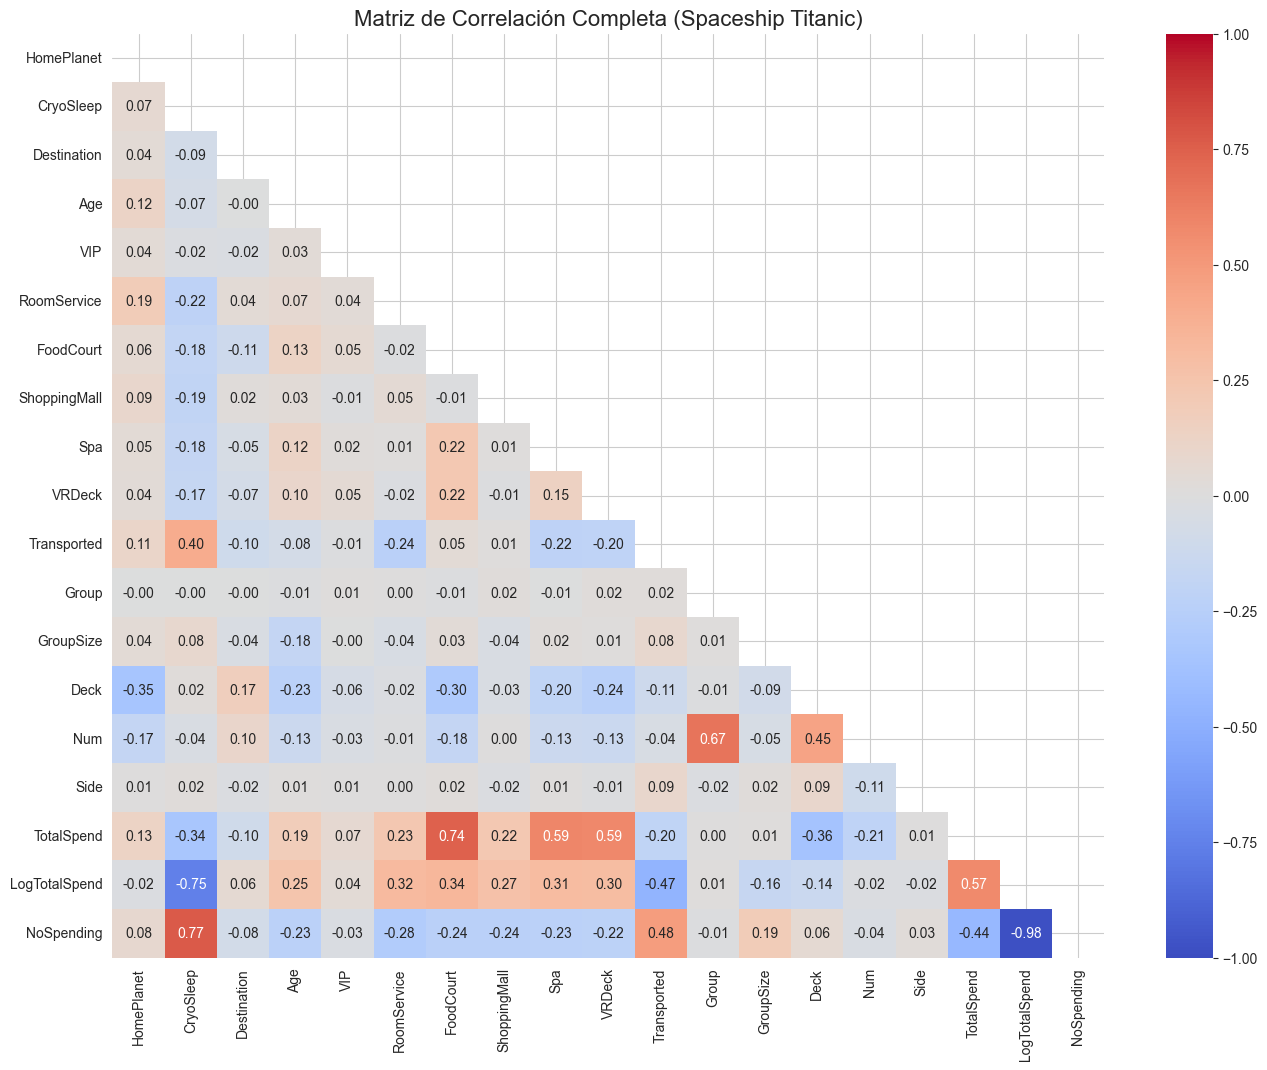

--- VARIABLES QUE MÁS AFECTAN A 'TRANSPORTED' ---
NoSpending       0.481628
CryoSleep        0.404716
HomePlanet       0.107755
Side             0.093319
GroupSize        0.082644
FoodCourt        0.045583
Group            0.021491
ShoppingMall     0.009391
VIP             -0.014260
Num             -0.043830
Age             -0.075026
Destination     -0.104817
Deck            -0.109925
TotalSpend      -0.199514
VRDeck          -0.204874
Spa             -0.218545
RoomService     -0.241124
LogTotalSpend   -0.468941
Name: Transported, dtype: float64


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. PREPARACIÓN DE DATOS (Corrección de errores + Extracción Numérica)
# ==========================================
df = pd.read_csv("train.csv")

# A. Extracción Estructural (Aquí arreglamos el error del Group)
df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
df['GroupSize'] = df.groupby('Group')['Group'].transform('count')

# B. Extracción de Cabin
df['Cabin'] = df['Cabin'].fillna("Unknown/-1/Unknown")
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
df['Num'] = pd.to_numeric(df['Num'], errors='coerce') # Variable numérica pura

# C. Ingeniería Económica (TotalSpend)
luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[luxury_cols] = df[luxury_cols].fillna(0)
df['TotalSpend'] = df[luxury_cols].sum(axis=1)
df['LogTotalSpend'] = np.log1p(df['TotalSpend']) # Escala logarítmica
df['NoSpending'] = (df['TotalSpend'] == 0).astype(int) # Binaria: ¿Gastó 0?

# D. Encoding Masivo para la Matriz
# Convertimos TODO lo que sea texto a números para ver su correlación
le = LabelEncoder()

# Variables categóricas a numerizar temporalmente
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Transported']

for col in cat_cols:
    # Rellenamos nulos con "Unknown" para no perder filas en la matriz
    df[col] = df[col].astype(str).fillna("Unknown")
    df[col] = le.fit_transform(df[col])

# ==========================================
# 2. VISUALIZACIÓN: MATRIZ DE CORRELACIÓN
# ==========================================
# Seleccionamos solo columnas numéricas (ahora todas lo son o las hemos convertido)
numeric_df = df.select_dtypes(include=[np.number])

# Calculamos la matriz
corr_matrix = numeric_df.corr()

# Graficamos
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Ocultar la mitad repetida
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación Completa (Spaceship Titanic)', fontsize=16)
plt.show()

# ==========================================
# 3. RANKING DE IMPACTO (Insights Numéricos)
# ==========================================
print("--- VARIABLES QUE MÁS AFECTAN A 'TRANSPORTED' ---")
# Ordenamos por valor absoluto de correlación
correlations = corr_matrix['Transported'].drop('Transported') # Quitamos la propia target
print(correlations.sort_values(ascending=False))

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. CARGA Y PREPARACIÓN MATEMÁTICA
# ==========================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# Unimos para procesar consistentemente
train['is_train'] = True
test['is_train'] = False
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# --- A. Ingeniería de las "Super Features" ---

# 1. Limpieza de Cabin (Estructural)
all_data['Cabin'] = all_data['Cabin'].fillna("Unknown/-1/Unknown")
all_data[['Deck', 'Num', 'Side']] = all_data['Cabin'].str.split('/', expand=True)

# 2. Ingeniería Económica (La clave de la correlación)
luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Rellenamos con 0 para poder calcular sumas exactas
all_data[luxury_cols] = all_data[luxury_cols].fillna(0)

all_data['TotalSpend'] = all_data[luxury_cols].sum(axis=1)
all_data['LogTotalSpend'] = np.log1p(all_data['TotalSpend']) # Tu feature estrella
all_data['NoSpending'] = (all_data['TotalSpend'] == 0).astype(int) # Tu feature #1

# 3. Lógica Cruzada (CryoSleep vs Gasto)
# Si gasta, NO duerme (Corrección de datos sucios)
all_data.loc[all_data['TotalSpend'] > 0, 'CryoSleep'] = False
# Si duerme, gasto es 0 (Refuerzo)
all_data.loc[all_data['CryoSleep'] == True, luxury_cols] = 0
all_data.loc[all_data['CryoSleep'] == True, 'TotalSpend'] = 0
all_data.loc[all_data['CryoSleep'] == True, 'LogTotalSpend'] = 0
all_data.loc[all_data['CryoSleep'] == True, 'NoSpending'] = 1

# Imputación final de CryoSleep (binaria)
all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False).astype(int)

# 4. Imputación Contextual de HomePlanet (Vital para Deck)
# A/B/C/T -> Europa, G -> Earth
all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'].fillna('Europa')
all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'] = all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'].fillna('Earth')
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('Earth') # Moda general para el resto

# --- B. Selección de Características (Noise Reduction) ---
# Eliminamos VIP, ShoppingMall, Name, Group, etc. por baja correlación
# Codificamos las categóricas restantes
le = LabelEncoder()
all_data['Deck'] = le.fit_transform(all_data['Deck'])
all_data['Side'] = le.fit_transform(all_data['Side'])
all_data['HomePlanet'] = le.fit_transform(all_data['HomePlanet'])
all_data['Destination'] = le.fit_transform(all_data['Destination'].fillna('TRAPPIST-1e'))

# LISTA FINAL DE VARIABLES (Solo las de alto impacto + contexto)
features = [
    'LogTotalSpend',  # -0.47 (Estrella)
    'NoSpending',     # +0.48 (Estrella)
    'CryoSleep',      # +0.40 (Estrella)
    'RoomService',    # -0.24 (Componente clave)
    'Spa',            # -0.22 (Componente clave)
    'VRDeck',         # -0.20 (Componente clave)
    'Deck',           # Contexto físico
    'Side',           # Contexto físico
    'HomePlanet',     # Contexto demográfico
    'Age'             # -0.07 (Baja correlación pero aporta matiz demográfico)
]
# Nota: Excluimos explícitamente VIP, ShoppingMall, FoodCourt por ser ruido.

# Separar train y test
X = all_data[all_data['is_train'] == True][features]
y = train['Transported'].astype(int)
X_test_submission = all_data[all_data['is_train'] == False][features]

# Validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. MODELADO: XGBOOST QUIRÚRGICO
# ==========================================
print("Entrenando XGBoost con Selección Matemática de Features...")

model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,   # Aprendizaje muy fino
    max_depth=4,          # Poca profundidad (evita overfitting, confiamos en las features fuertes)
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# ==========================================
# 3. EVALUACIÓN FINAL
# ==========================================
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"\n--- ACCURACY FINAL (MATH SELECT): {acc:.4f} ---")

# Importancia para verificar tu intuición
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nRanking Real de Importancia para el Modelo:")
print(feature_importances)

# Generar Submission
final_preds = model.predict(X_test_submission)
submission['Transported'] = final_preds.astype(bool)
submission.to_csv('submission_math_select.csv', index=False)
print("\nArchivo 'submission_math_select.csv' generado.")

Entrenando XGBoost con Selección Matemática de Features...
[0]	validation_0-logloss:0.68950	validation_1-logloss:0.68947
[100]	validation_0-logloss:0.51242	validation_1-logloss:0.51677


C:\Users\Lucia\AppData\Local\Temp\ipykernel_28120\3915994117.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False).astype(int)


[200]	validation_0-logloss:0.45474	validation_1-logloss:0.46564
[300]	validation_0-logloss:0.42809	validation_1-logloss:0.44698
[400]	validation_0-logloss:0.41302	validation_1-logloss:0.43830
[500]	validation_0-logloss:0.40340	validation_1-logloss:0.43353
[600]	validation_0-logloss:0.39550	validation_1-logloss:0.43014
[700]	validation_0-logloss:0.38914	validation_1-logloss:0.42788
[800]	validation_0-logloss:0.38368	validation_1-logloss:0.42555
[900]	validation_0-logloss:0.37852	validation_1-logloss:0.42299
[999]	validation_0-logloss:0.37411	validation_1-logloss:0.42220

--- ACCURACY FINAL (MATH SELECT): 0.7861 ---

Ranking Real de Importancia para el Modelo:
NoSpending       0.790901
HomePlanet       0.049413
CryoSleep        0.035466
VRDeck           0.022118
RoomService      0.021255
Deck             0.021000
Spa              0.020857
LogTotalSpend    0.018892
Side             0.013175
Age              0.006923
dtype: float32

Archivo 'submission_math_select.csv' generado.


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# ==========================================
# 1. CARGA DE DATOS
# ==========================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# ==========================================
# 2. FEATURE ENGINEERING (HYBRID)
# ==========================================

# --- A. Extracción Estructural ---
# Group Extraction (Vital para imputación)
all_data['Group'] = all_data['PassengerId'].apply(lambda x: x.split('_')[0])
all_data['GroupSize'] = all_data.groupby('Group')['Group'].transform('count')

# Cabin Extraction
all_data['Cabin'] = all_data['Cabin'].fillna("Unknown/-1/Unknown")
all_data[['Deck', 'Num', 'Side']] = all_data['Cabin'].str.split('/', expand=True)
all_data['Num'] = pd.to_numeric(all_data['Num'], errors='coerce').fillna(-1)

# Cabin Region (Discretización para ayudar al modelo)
all_data['CabinRegion'] = pd.cut(all_data['Num'], bins=3, labels=['Bow', 'Mid', 'Stern']).astype(str)

# --- B. Limpieza Lógica (Económica) ---
luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
all_data[luxury_cols] = all_data[luxury_cols].fillna(0).astype(float)

all_data['TotalSpend'] = all_data[luxury_cols].sum(axis=1)
all_data['LogTotalSpend'] = np.log1p(all_data['TotalSpend'])
all_data['NoSpending'] = (all_data['TotalSpend'] == 0).astype(int) # Feature Estrella

# Lógica Cruzada: Gasto <-> CryoSleep
mask_spenders = all_data['TotalSpend'] > 0
all_data.loc[mask_spenders, 'CryoSleep'] = False

mask_sleepers = all_data['CryoSleep'] == True
all_data.loc[mask_sleepers, luxury_cols] = 0
all_data.loc[mask_sleepers, 'TotalSpend'] = 0
all_data.loc[mask_sleepers, 'LogTotalSpend'] = 0
all_data.loc[mask_sleepers, 'NoSpending'] = 1

all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False).astype(int)

# --- C. Imputación Contextual (HomePlanet) ---
# 1. Por Deck (Regla Física)
all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'].fillna('Europa')
all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'] = all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'].fillna('Earth')

# 2. Por Grupo (Regla Social)
group_homeplanet = all_data.groupby('Group')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_data['HomePlanet'] = all_data['HomePlanet'].fillna(group_homeplanet)

# 3. Fallback
all_data['HomePlanet'] = all_data['HomePlanet'].fillna('Earth')

# --- D. Feature Generation Extra ---
# IsChild (Regla Demográfica)
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['IsChild'] = (all_data['Age'] < 13).astype(int)

# --- E. Encoding ---
# Label Encoding para variables con cierto orden o binarias
le = LabelEncoder()
cols_to_le = ['Deck', 'Side', 'CabinRegion', 'HomePlanet', 'Destination']
for col in cols_to_le:
    all_data[col] = all_data[col].astype(str) # Asegurar string
    all_data[col] = le.fit_transform(all_data[col])

all_data['VIP'] = all_data['VIP'].fillna(False).astype(int)

# ==========================================
# 3. PREPARACIÓN FINAL
# ==========================================
# Mantenemos TODAS las features útiles. No borramos nada.
features = [
    'Deck', 'Side', 'Num', 'CabinRegion', # Ubicación
    'HomePlanet', 'Destination',          # Origen/Destino
    'CryoSleep', 'Age', 'VIP', 'IsChild', # Estado Personal
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', # Gastos Finos
    'TotalSpend', 'LogTotalSpend', 'NoSpending', # Gastos Agregados
    'GroupSize' # Contexto Social
]

X = all_data[all_data['dataset'] == 'train'][features]
y = train['Transported'].astype(int)
X_test_submission = all_data[all_data['dataset'] == 'test'][features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. DEFINICIÓN DE MODELOS BASE (Tus Campeones)
# ==========================================
# Usamos los hiperparámetros que ya te funcionaron bien
rf_params = {
    'n_estimators': 1000,
    'max_depth': 14,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.015,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'enable_categorical': True
}

# ==========================================
# 3. BUCLE DE CROSS-VALIDATION (El Motor de Mejora)
# ==========================================
N_FOLDS = 10  # Subimos a 10 folds para máxima robustez (estándar de oro)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Arrays para guardar resultados
oof_preds = np.zeros(len(X))                 # Predicciones Out-Of-Fold (Validación)
test_preds = np.zeros(len(X_test_submission)) # Predicciones acumuladas para Test

print(f"Iniciando Entrenamiento con {N_FOLDS}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    # Separar datos del fold actual
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Instanciar modelos frescos
    rf = RandomForestClassifier(**rf_params)
    xgb = XGBClassifier(**xgb_params)

    # Crear Ensemble
    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        voting='soft',
        weights=[1, 1.2] # Mantenemos tu peso ganador
    )

    # Entrenar
    ensemble.fit(X_train_fold, y_train_fold)

    # Predecir en Validación (para calcular accuracy real)
    # [:, 1] nos da la probabilidad de la clase "True" (Transported)
    val_probs = ensemble.predict_proba(X_val_fold)[:, 1]
    oof_preds[val_idx] = val_probs

    # Predecir en Test (Acumulamos)
    test_probs = ensemble.predict_proba(X_test_submission)[:, 1]
    test_preds += test_probs / N_FOLDS

    # Métrica del fold
    fold_acc = accuracy_score(y_val_fold, (val_probs > 0.5).astype(int))
    print(f"Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.4f}")

# ==========================================
# 4. EVALUACIÓN FINAL AGREGADA
# ==========================================
total_acc = accuracy_score(y, (oof_preds > 0.5).astype(int))
print(f"\n--- ACCURACY GLOBAL OOF (Estimación Realista): {total_acc:.4f} ---")

# ==========================================
# 5. SUBMISSION
# ==========================================
# Convertimos el promedio de probabilidades a True/False
final_submission_preds = (test_preds > 0.5).astype(bool)

submission['Transported'] = final_submission_preds
submission.to_csv('submission_cv_ensemble.csv', index=False)
print("Archivo 'submission_cv_ensemble.csv' generado con éxito.")

C:\Users\Lucia\AppData\Local\Temp\ipykernel_28120\34181455.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False).astype(int)
C:\Users\Lucia\AppData\Local\Temp\ipykernel_28120\34181455.py:83: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data['VIP'] = all_data['VIP'].fillna(False).astype(int)


Iniciando Entrenamiento con 10-Fold Cross-Validation...
Fold 1/10 - Accuracy: 0.8023
Fold 2/10 - Accuracy: 0.8264
Fold 3/10 - Accuracy: 0.8195
Fold 4/10 - Accuracy: 0.7963
Fold 5/10 - Accuracy: 0.8124
Fold 6/10 - Accuracy: 0.8182
Fold 7/10 - Accuracy: 0.8205
Fold 8/10 - Accuracy: 0.8021
Fold 9/10 - Accuracy: 0.8101
Fold 10/10 - Accuracy: 0.8044

--- ACCURACY GLOBAL OOF (Estimación Realista): 0.8112 ---
Archivo 'submission_cv_ensemble.csv' generado con éxito.


c:\Users\Lucia\Documents\GitHub\lusanmanso.kaggle.com\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


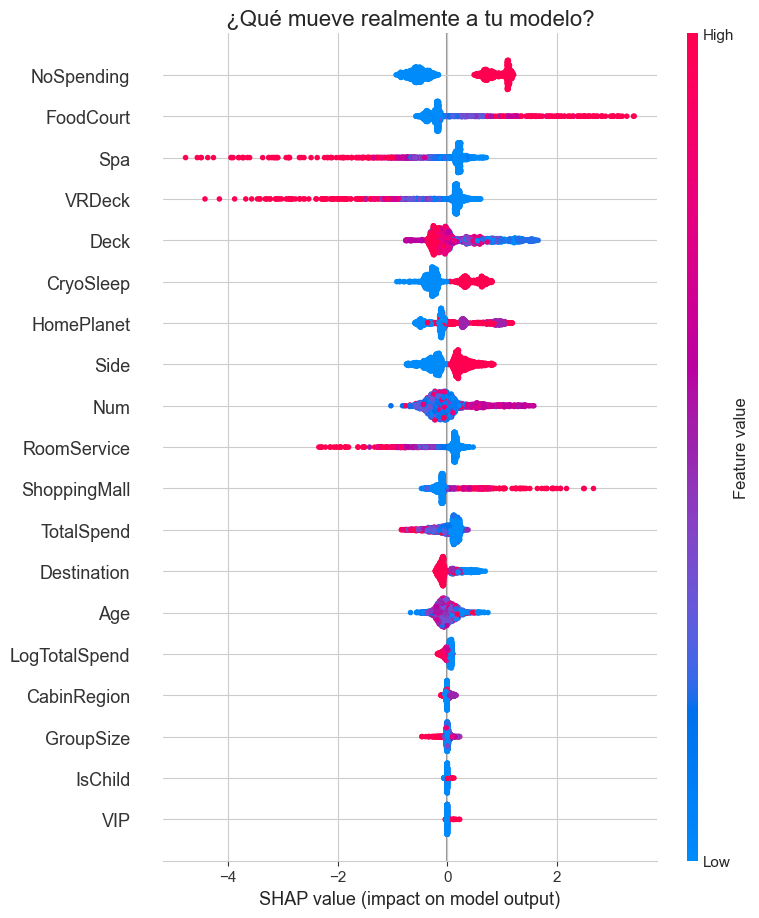

In [20]:
import shap
import matplotlib.pyplot as plt

# 1. Extraemos el modelo XGBoost del Ensemble entrenado
# (El VotingClassifier tiene un atributo 'estimators_' que es una lista de (nombre, modelo))
# Accedemos al modelo 'xgb' que es el segundo elemento [1] de la lista, y tomamos el objeto [1]
trained_xgb = ensemble.named_estimators_['xgb']

# 2. Preparamos el Explainer
# Usamos TreeExplainer, optimizado para árboles
explainer = shap.TreeExplainer(trained_xgb)

# 3. Calculamos los SHAP values sobre el set de validación
shap_values = explainer.shap_values(X_val)

# 4. Visualización: Summary Plot (El gráfico más potente de ML)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_val, show=False)
plt.title("¿Qué mueve realmente a tu modelo?", fontsize=16)
plt.show()

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier # <--- El nuevo fichaje
from sklearn.preprocessing import LabelEncoder

# Configuración
pd.set_option('future.no_silent_downcasting', True)

# ==========================================
# 1. CARGA Y PREPARACIÓN (Mantenemos la lógica ganadora)
# ==========================================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

# --- Feature Engineering Híbrido (El que funcionó) ---
all_data['Group'] = all_data['PassengerId'].apply(lambda x: x.split('_')[0])
all_data['GroupSize'] = all_data.groupby('Group')['Group'].transform('count')

all_data['Cabin'] = all_data['Cabin'].fillna("Unknown/-1/Unknown")
all_data[['Deck', 'Num', 'Side']] = all_data['Cabin'].str.split('/', expand=True)
all_data['Num'] = pd.to_numeric(all_data['Num'], errors='coerce').fillna(-1)
all_data['CabinRegion'] = pd.cut(all_data['Num'], bins=3, labels=['Bow', 'Mid', 'Stern']).astype(str)

# Limpieza Económica
luxury_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
all_data[luxury_cols] = all_data[luxury_cols].fillna(0).astype(float)
all_data['TotalSpend'] = all_data[luxury_cols].sum(axis=1)
all_data['LogTotalSpend'] = np.log1p(all_data['TotalSpend'])
all_data['NoSpending'] = (all_data['TotalSpend'] == 0).astype(int)

# Lógica Cruzada
mask_spenders = all_data['TotalSpend'] > 0
all_data.loc[mask_spenders, 'CryoSleep'] = False
mask_sleepers = all_data['CryoSleep'] == True
all_data.loc[mask_sleepers, luxury_cols] = 0
all_data.loc[mask_sleepers, 'TotalSpend'] = 0
all_data.loc[mask_sleepers, 'LogTotalSpend'] = 0
all_data.loc[mask_sleepers, 'NoSpending'] = 1
all_data['CryoSleep'] = all_data['CryoSleep'].fillna(False).astype(int)

# Imputación Contextual
all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'] = all_data.loc[all_data['Deck'].isin(['A', 'B', 'C', 'T']), 'HomePlanet'].fillna('Europa')
all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'] = all_data.loc[all_data['Deck'] == 'G', 'HomePlanet'].fillna('Earth')
group_homeplanet = all_data.groupby('Group')['HomePlanet'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
all_data['HomePlanet'] = all_data['HomePlanet'].fillna(group_homeplanet).fillna('Earth')

# Demografía
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].median())
all_data['IsChild'] = (all_data['Age'] < 13).astype(int)
all_data['VIP'] = all_data['VIP'].fillna(False).astype(int)

# Encoding
le = LabelEncoder()
# Nota: CatBoost prefiere recibir las categorías tal cual, pero como estamos en un Voting
# con RF y XGB, mantendremos el LabelEncoding para consistencia.
cols_to_le = ['Deck', 'Side', 'CabinRegion', 'HomePlanet', 'Destination']
for col in cols_to_le:
    all_data[col] = all_data[col].astype(str)
    all_data[col] = le.fit_transform(all_data[col])

features = [
    'Deck', 'Side', 'Num', 'CabinRegion',
    'HomePlanet', 'Destination',
    'CryoSleep', 'Age', 'VIP', 'IsChild',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
    'TotalSpend', 'LogTotalSpend', 'NoSpending',
    'GroupSize'
]

X = all_data[all_data['dataset'] == 'train'][features]
y = train['Transported'].astype(int)
X_test_submission = all_data[all_data['dataset'] == 'test'][features]

# ==========================================
# 2. DEFINICIÓN DE MODELOS (Parámetros Robustos)
# ==========================================
# Usamos las configuraciones que ya sabes que funcionan (sin sobre-optimizar)

rf_params = {
    'n_estimators': 1000,
    'max_depth': 14,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

xgb_params = {
    'n_estimators': 800,
    'learning_rate': 0.015,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'logloss',
    'enable_categorical': True
}

# CATBOOST: Configuración robusta por defecto
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.015,
    'depth': 6,
    'l2_leaf_reg': 3,          # Regularización nativa
    'random_seed': 42,
    'verbose': 0,              # Silencioso
    'allow_writing_files': False
}

# ==========================================
# 3. K-FOLD VOTING LOOP (El Ganador + CatBoost)
# ==========================================
N_FOLDS = 10
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test_submission))

print(f"Iniciando Tridente Ensemble con {N_FOLDS}-Fold CV...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    # Instancias frescas
    rf = RandomForestClassifier(**rf_params)
    xgb = XGBClassifier(**xgb_params)
    cat = CatBoostClassifier(**cat_params)

    # Voting Classifier con 3 cabezas
    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
        voting='soft',
        weights=[1, 1.2, 1.2] # Damos peso a los Boostings (XGB + Cat)
    )

    ensemble.fit(X_train_fold, y_train_fold)

    # Predicciones
    val_probs = ensemble.predict_proba(X_val_fold)[:, 1]
    oof_preds[val_idx] = val_probs

    test_probs = ensemble.predict_proba(X_test_submission)[:, 1]
    test_preds += test_probs / N_FOLDS

    fold_acc = accuracy_score(y_val_fold, (val_probs > 0.5).astype(int))
    print(f"Fold {fold+1} Accuracy: {fold_acc:.4f}")

# ==========================================
# 4. RESULTADOS Y SUBMISSION
# ==========================================
total_acc = accuracy_score(y, (oof_preds > 0.5).astype(int))
print(f"\n--- ACCURACY OOF FINAL (Tridente): {total_acc:.4f} ---")

submission['Transported'] = (test_preds > 0.5).astype(bool)
submission.to_csv('submission_trident_cv.csv', index=False)
print("Archivo generado. Confía en la media de 30 modelos (3 modelos x 10 folds).")

Iniciando Tridente Ensemble con 10-Fold CV...
Fold 1 Accuracy: 0.8023
Fold 2 Accuracy: 0.8299
Fold 3 Accuracy: 0.8276
Fold 4 Accuracy: 0.7963
Fold 5 Accuracy: 0.8170
Fold 6 Accuracy: 0.8193
Fold 7 Accuracy: 0.8274
Fold 8 Accuracy: 0.8055
Fold 9 Accuracy: 0.8147
Fold 10 Accuracy: 0.8067

--- ACCURACY OOF FINAL (Tridente): 0.8147 ---
Archivo generado. Confía en la media de 30 modelos (3 modelos x 10 folds).


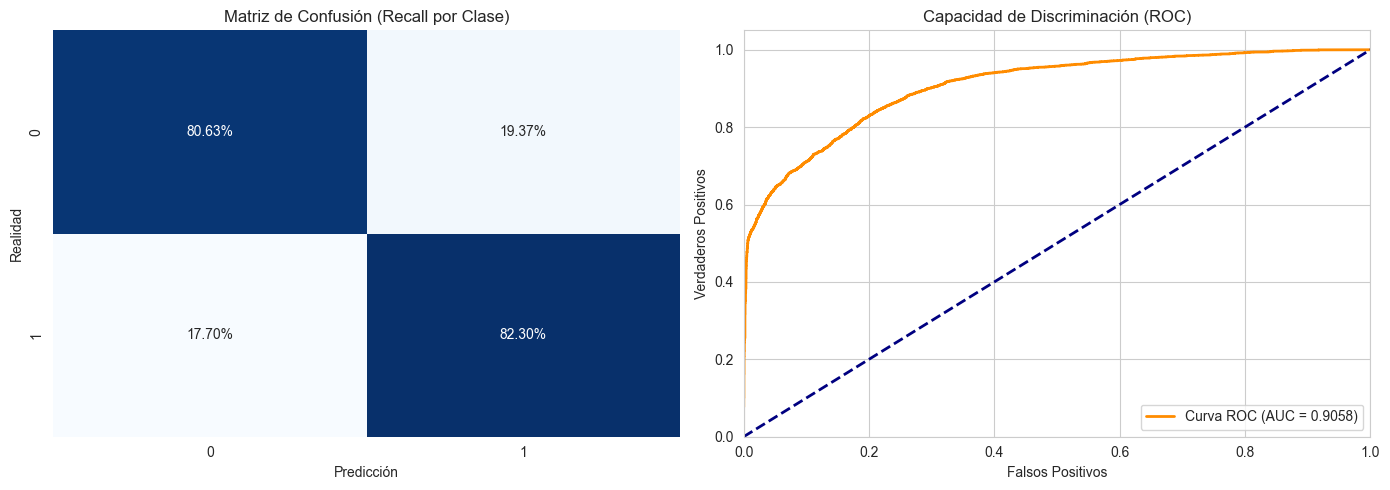


--- INFORME DE CLASIFICACIÓN ---
                 precision    recall  f1-score   support

No Transportado       0.82      0.81      0.81      4315
   Transportado       0.81      0.82      0.82      4378

       accuracy                           0.81      8693
      macro avg       0.81      0.81      0.81      8693
   weighted avg       0.81      0.81      0.81      8693



In [29]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# ANÁLISIS FORENSE DEL MODELO (OOF)
# ==========================================

# 1. Matriz de Confusión Normalizada
# Nos dice: "De los que eran Transportados, ¿cuántos pillé?"
cm = confusion_matrix(y, (oof_preds > 0.5).astype(int), normalize='true')

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión (Recall por Clase)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

# 2. Curva ROC
# Nos dice qué tan bien separa las clases independientemente del umbral 0.5
fpr, tpr, thresholds = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Capacidad de Discriminación (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 3. Informe Numérico Detallado
print("\n--- INFORME DE CLASIFICACIÓN ---")
print(classification_report(y, (oof_preds > 0.5).astype(int), target_names=['No Transportado', 'Transportado']))

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score

# Buscamos el umbral exacto que maximiza el accuracy en tus datos de validación
thresholds = np.arange(0.40, 0.60, 0.001)
accuracies = []

for t in thresholds:
    # Calculamos accuracy asumiendo que el corte es 't'
    acc = accuracy_score(y, (oof_preds > t).astype(int))
    accuracies.append(acc)

# Encontramos el ganador
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_acc = accuracies[best_idx]

print(f"--- ANÁLISIS DE UMBRAL ---")
print(f"Umbral Estándar (0.50): {total_acc:.5f}")
print(f"Umbral Óptimo ({best_threshold:.3f}): {best_acc:.5f}")

# GENERACIÓN FINAL (Solo si el óptimo mejora el estándar)
if best_acc > total_acc:
    print("\n¡Mejora detectada! Generando 'submission_optimized_threshold.csv'...")
    final_preds_optimized = (test_preds > best_threshold).astype(bool)
    submission['Transported'] = final_preds_optimized
    submission.to_csv('submission_optimized_threshold.csv', index=False)
else:
    print("\nEl umbral estándar de 0.50 ya era perfecto. Usa 'submission_trident_cv.csv'.")

--- ANÁLISIS DE UMBRAL ---
Umbral Estándar (0.50): 0.81468
Umbral Óptimo (0.502): 0.81525

¡Mejora detectada! Generando 'submission_optimized_threshold.csv'...
